In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

import os
logdir='./Atari_GAE/'
logging_interval = 100
animate_interval = logging_interval * 5

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

<h2>Use CUDA</h2>

In [3]:
use_cuda = torch.cuda.is_available()
print("Using CUDA: {}".format(use_cuda))
device   = torch.device("cuda" if use_cuda else "cpu")

Using CUDA: False


<h2>Create Environments</h2>

In [4]:
import sys
sys.path.insert(0, "/home/jeff/Documents/ECE276C/hw4/Courses_Repo18-20/Reinforcement_learning18/RL-Adventure-2/common")

from common import multiprocessing_env
from multiprocessing_env import SubprocVecEnv

num_envs = 1
#env_name = "Pendulum-v0"
env_name = 'Pong-v0' 

#def make_env():
#    def _thunk():
#        env = gym.make(env_name)
#        return env
#    return _thunk

#envs = [make_env() for i in range(num_envs)]
#envs = SubprocVecEnv(envs)

env = gym.make(env_name)

[2018-06-02 14:47:31,175] Making new env: Pong-v0


In [5]:
VISUALIZE = True
SEED = 0 
MAX_PATH_LENGTH = 500 
NUM_EPISODES = 12000
if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)

#Need to look through code more before setting this. 
#env._max_episode_steps = MAX_PATH_LENGTH


[2018-06-02 14:47:32,809] Clearing 4 monitor files from previous run (because force=True was provided)


<h2>Neural Network</h2>

In [6]:
class DQN(nn.Module):
    def __init__(self, num_in, num_out, hidden_size):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_in, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features=7*7*64, out_features=hidden_size)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=num_out)        
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0., std=0.1)
        nn.init.constant_(m.bias, 0.1)


class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size, std=0.0):
        super(ActorCritic, self).__init__()
        
        self.critic = DQN(num_inputs, 1, hidden_size)
        self.actor = DQN(num_inputs, num_outputs, hidden_size)
        
        self.log_std = nn.Parameter(torch.ones(1, num_outputs) * std)
        
        self.critic.apply(init_weights)
        self.actor.apply(init_weights)
        
    def forward(self, x):
        value = self.critic(x)
        mu    = self.actor(x)
        std   = self.log_std.exp().expand_as(mu)
        dist  = Normal(mu, std)
        return dist, value

In [65]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()
    
def test_env(vis=False):
    try:
        state = env.reset()
    except:
        while(True):
            a, b, c, d = env.step(0)
            if c:
                break
        state = env.reset()
        
    if vis: env.render()
        
    done = False
    total_reward = 0
    state, _, _ = step(0)
    while not done:
#        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        dist, _ = model(state)
        next_state, reward, done = step(np.argmax(dist.sample().cpu().numpy()))
        state = next_state
        if vis: env.render()
        total_reward += reward
    env.reset()
    return total_reward

<h1>High-Dimensional Continuous Control Using Generalized Advantage Estimation</h1>
<h3><a href="https://arxiv.org/abs/1506.02438">Arxiv</a></h3>

In [9]:
def compute_gae(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    values = values + [next_value]
    gae = 0
    returns = []
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
    return returns

In [10]:
# feed in 4 frames
num_inputs  = 4

# number of actions
num_outputs = env.action_space.n
print(num_outputs)

#Hyper params:
hidden_size = 512
lr          = 1e-4
num_steps   = 20

model = ActorCritic(num_inputs, num_outputs, hidden_size).to(device)
optimizer = optim.Adam(model.parameters())

6


In [42]:
import numpy as np
from PIL import Image

def process_state(frame):
    # rid of extra dim
    img = np.reshape(frame, [210, 160, 3])
    # convert to b/w
    img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
    # resize
    img = Image.fromarray(img)
    resized_screen = img.resize((84, 84), Image.BILINEAR)
    resized_screen = np.array(resized_screen)
    return np.reshape(resized_screen, [1,84,84])

def stack(slist):
    frames = np.zeros([4, 84, 84])
    for i in range(4):
#        frames[i, :, :] = process_state(slist[i].permute(0,3,1,2).cpu().numpy())
        frames[i, :, :] = process_state(slist[i])
    return torch.FloatTensor(frames.reshape([1,4,84,84])).to(device)

def step(action):
    states = []
    reward = []
    for i in range(4):
        s, r, d, _ = env.step(action)
#        print(s)
        states.append(s)
        reward.append(r)
        if d:
            for j in range(3-i):
                states.append(s)
            return stack(states), sum(reward)/len(reward), d
    return stack(states), sum(reward)/len(reward), d
        

In [44]:
max_frames   = 1000000
frame_idx    = 0
test_rewards = []

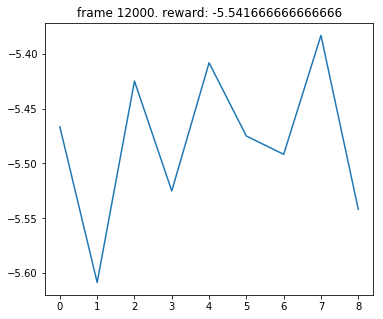

In [ ]:
# create first "state"
state = env.reset()
state, _, _ = step(0)
done = False

while frame_idx < max_frames:

    log_probs = []
    values    = []
    rewards   = []
    masks     = []
    entropy = 0
    
    if done:
        state = env.reset()
        state, _, _ = step(0)

    for _ in range(num_steps):
#        state = torch.FloatTensor(state).to(device)
        dist, value = model(state)

        action = dist.sample()
#        print(action)
#        print(state.size())
        next_state, reward, done = step(np.argmax(action.cpu().numpy()))
        if done:
            break

        log_prob = dist.log_prob(action)
        entropy += dist.entropy().mean()
        
        log_probs.append(log_prob)
        values.append(value)
        rewards.append(torch.FloatTensor(np.array(reward)).unsqueeze(0).to(device))
        masks.append(torch.FloatTensor(np.array(1 - done)).unsqueeze(0).to(device))
        
        state = next_state
        frame_idx += 1
        
        if frame_idx % 1000 == 0:
            test_rewards.append(np.mean([test_env() for _ in range(10)]))
            plot(frame_idx, test_rewards)
            
    next_state = torch.FloatTensor(next_state).to(device)
    _, next_value = model(next_state)
    returns = compute_gae(next_value, rewards, masks, values)
    
    log_probs = torch.cat(log_probs)
    returns   = torch.cat(returns).detach()
    values    = torch.cat(values)

    advantage = returns - values

    actor_loss  = -(log_probs * advantage.detach()).mean()
    critic_loss = advantage.pow(2).mean()

    loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
test_env(True)

In [63]:
while(True):
    a, b, c, d = env.step(0)
    if c:
        break
env.reset()

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ...,
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ...,
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       ...,

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ...,
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]],

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ...,
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]],

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ...,
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24]]